# Imports

In [43]:
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
import requests

In [44]:
toy_X = np.array([1.,2.,3.])
toy_y = np.array([9.,7.,2.])

# Goal 1: Get a much bigger dataset that is interesting

In [45]:
csv = requests.get("http://www.aayanarish.com/ml_datasets/AAPL.csv").text

data = csv.split("\n")
data = [data[i].split(",") for i in range(len(data)) if i > 1 and i < len(data)-1]
dates, price, *_ = list(zip(*data))
print(len(dates), len(price))
dates = np.array(dates)
price = np.array(price, dtype=np.float32)
print("Samples: ")
print(" Dates\t\tPrice")
print(*zip(dates[:10], price[:10]), sep="\n")

9908 9908
Samples: 
 Dates		Price
('1980-12-15', 0.4888393)
('1980-12-16', 0.453125)
('1980-12-17', 0.46205357)
('1980-12-18', 0.47544643)
('1980-12-19', 0.50446427)
('1980-12-22', 0.52901787)
('1980-12-23', 0.55133927)
('1980-12-24', 0.58035713)
('1980-12-26', 0.6339286)
('1980-12-29', 0.64285713)


Text(0, 0.5, 'Stock price')

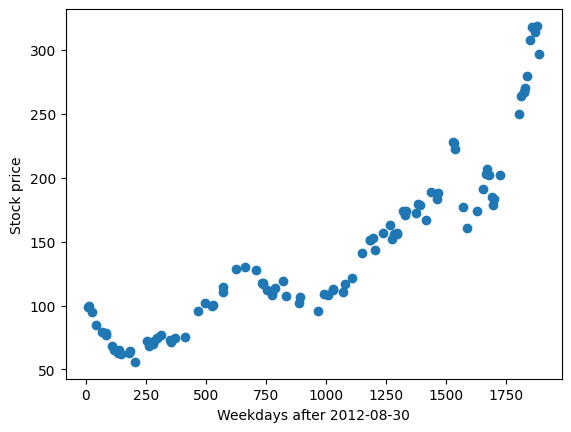

In [46]:
strt = 8000
inds = np.arange(strt, len(dates))
rng = np.random.default_rng(16)
nds = rng.choice(inds, (100))
X, y = nds-strt, price[nds]
plt.scatter(X, y)
plt.xlabel(f"Weekdays after {dates[strt]}")
plt.ylabel("Stock price")

# Model

In [47]:
FF = lambda x: np.array([x])

In [48]:
class Optimizer():
    def __init__(self) -> None:
        pass

    def __call__(self, w, b, X, y, lr) -> tuple[int, int]:
        pass

In [49]:
class LinearRegression:
    def __init__(self, w, b, loss, grad=None, optimizer=None):
        self.w = w
        self.b = b
        self.main_loss = loss
        self.main_grad = grad
        self.optimizer = optimizer

    def predict(self, T):
        return self.w * T + self.b

    def plot(self):
        # plot the line drawn by the model
        pass

    def step(self, X, y, lr):
        """
        Allows for different w and b params, but defalt to same
        """
        dw, db = self.main_grad(self.w, self.b, X, y)
        self.w -= lr * dw
        self.b -= lr * db
        return self.w, self.b

    def train(self, X, y, lr, steps, ret_pts = False):
        ws, bs = np.zeros((steps+1)), np.zeros((steps+1))
        ws[0] = self.w
        bs[0] = self.b
        for i in range(steps):
            if self.optimizer is not None:
                self.w, self.b = self.optimizer(self.w, self.b, X, y, lr)
            else:
                self.w, self.b = self.step(X, y, lr)
            ws[i+1] = self.w
            bs[i+1] = self.b
        if ret_pts:
            return ws, bs
        return self.w, self.b
    '''
    static fns below
    '''

    def l1_grad(w, b, X, y):
        """
        ```
        loss = mean( |w*X + b - y| )  
        dw   = mean( sign(w*X + b - y)*X )
        db   = mean( sign(w*X + b - y)   )
        ```
        """
        pur = np.sign(LinearRegression.l1_loss(np.array([w]), np.array([b]), X, y, pure=1, do_abs=0).flatten())
        dw = np.mean(pur*X)
        db = np.mean(pur)
        return dw, db

    def l2_grad(w, b, X, y):
        """
        ```
        loss = mean( (w*X + b - y)^2 )  
        dw   = mean( 2*(w*X+b-y)*X )
        db   = mean( 2*(w*X+b-y)   ) 
        ``` 
        """
        ls = LinearRegression.l1_loss(np.array([w]), np.array([b]), X, y, do_abs=0, pure=1).flatten()
        dw = np.mean(2*ls*X)
        dh = np.mean(2*ls)
        return dw, dh

    def toy_grad(w, b, X, y):
        # this is toy, so ignore X and y params
        dw = 20 * (w - 2)
        db = 2 * (b - 1)
        return dw, db
    
    def quickloss(w, b, X, y, pw=1, pure=0, do_abs=1):
        '''
        Quick loss function for testing multiple ws and bs over some X and y data

        ---
        w: the _list_ of ws to test on  
        b: the _list_ of bs to test on  
        X: the _list_ of input values to use for calculating the loss
        y: the _list_ of output values to use for calculating the loss 
        pw: the power for the loss (`1` means L1 loss, `2` means L2, etc)  
        pure: whether to return the whole array (True) or just the mean (False) 
        '''
        if not (isinstance(w, np.ndarray)): w = FF(w)
        if not (isinstance(b, np.ndarray)): b = FF(b)
        vl = (w.flatten()[None, :]*X[:, None] + b.flatten()[None, :]) - y[:, None]
        if (do_abs):
            vl = np.abs(vl)
        vl = vl**pw
        if (pure):
            return vl
        return np.mean(vl, axis=0).reshape(w.shape)

    def l2_loss(*args, **kwargs):
        kwargs.pop("pw", None)
        return LinearRegression.quickloss(*args, **kwargs, pw=2)
    
    def l1_loss(*args, **kwargs):
        kwargs.pop("pw", None)
        return LinearRegression.quickloss(*args, **kwargs, pw=1)

    def toy_loss(w, b, *args, **kwargs):
        return 10 * (w - 2) ** 2 + (b - 1) ** 2 
    

Loss: [54.7431712]


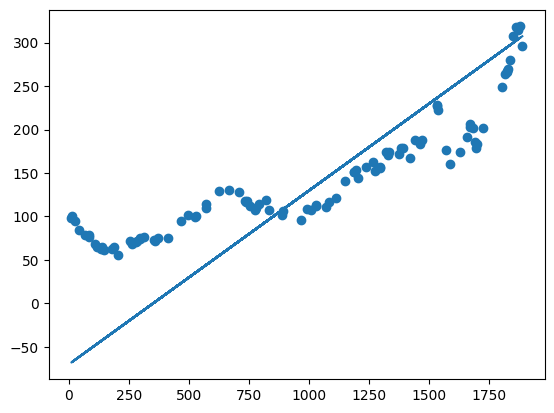

In [50]:
w = 0.2
b = -70
model = LinearRegression(w, b, LinearRegression.l1_loss)
print("Loss:", LinearRegression.l1_loss(FF(w), FF(b), X, y))
plt.scatter(X, y)
plt.plot(X, model.predict(X))

# Goal 2: Contour plot of L1 loss and L2 loss

### Functions

loss function(s)

contour plotting

In [51]:
def plotContour(ws, bs, X, y, loss, levels=np.arange(0, 100, 10), do3d = False):
    """
    Plots a contour of the loss for some ws and bs, given some test data.  

    ---
    ws: the list of ws to plot the loss of  
    bs: the list of bs to plot the loss of  
    X: the list of input values to use for calculating the loss
    y: the list of output values to use for calculating the loss  
    loss: the loss function to use. Should take in the ws and bs.
    levels: the list of levels to display (defaults to `0, 10, 20, ..., 100`)  
    do3d: whether to plot 3d or not. As in, if this is false (by default), will display a normal contour plot. Otherwise, the function will display a 3d surface plot of the loss.  
    """
    ww, bb = np.meshgrid(ws, bs)
    res = loss(ww, bb, X, y)
    if not do3d:
        plt.contour(ww, bb, res, levels, cmap=cm.coolwarm)
    else:
        # not technically a contour plot, but it works
        ax = plt.figure().add_subplot(projection='3d')
        ax.plot_surface(ww, bb, res, cmap=cm.coolwarm)

### Test Data

In [52]:
# don't worry about this
toy_lvls = [0]*3

toy loss function


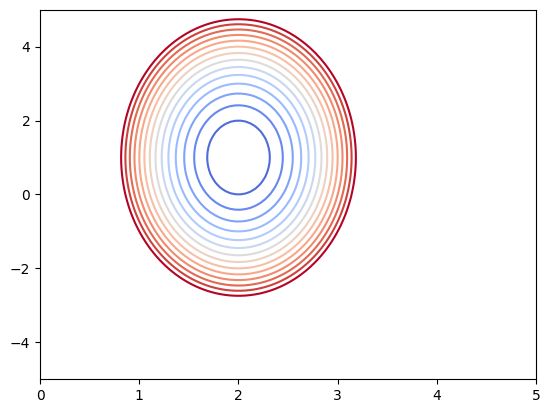

In [53]:
w_contour_toy = np.linspace(0, 5, 100)
b_contour_toy = np.linspace(-5, 5, 100)
toy_lvls[1] = np.arange(0, 15, 1)
plotContour(w_contour_toy, b_contour_toy, toy_X, toy_y, LinearRegression.toy_loss, levels=toy_lvls[1])

L1 contour

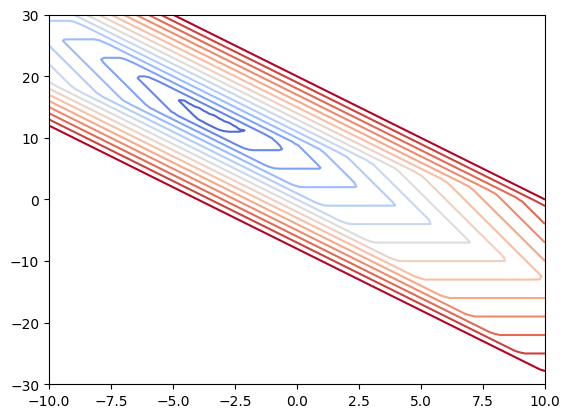

In [54]:
w_contour_toy_l1 = np.linspace(-10, 10, 100)
b_contour_toy_l1 = np.linspace(-30, 30, 100)
toy_lvls[1] = np.arange(0, 15, 1)
plotContour(w_contour_toy_l1, b_contour_toy_l1, toy_X, toy_y, LinearRegression.l1_loss, levels=toy_lvls[1])

L2 contour

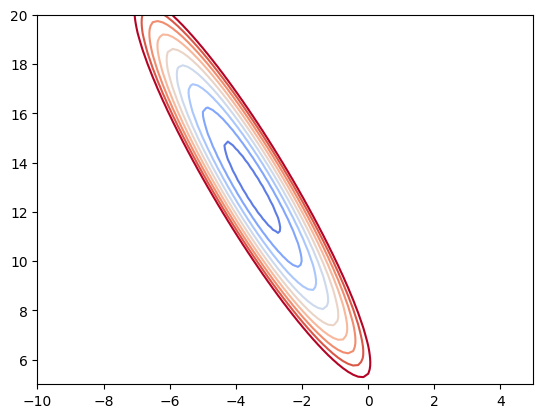

In [55]:
w_contour_toy_l2 = np.linspace(-10, 5, 100)
b_contour_toy_l2 = np.linspace(5, 20, 100)
toy_lvls[2] = np.arange(0, 10, 1)
plotContour(w_contour_toy_l2, b_contour_toy_l2, toy_X, toy_y, LinearRegression.l2_loss, levels=toy_lvls[2])

### My data

In [56]:
# don't worry about this
lvls = [0]*3

L1 contour

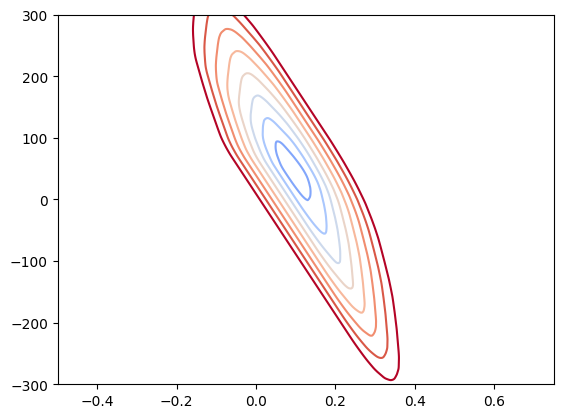

In [57]:
# contour of data with l1
w_contour = np.linspace(-0.5, 0.75, 400)
b_contour = np.linspace(-300, 300, 400)
lvls[1] = np.arange(0, 150, 15)
plotContour(w_contour, b_contour, X, y, LinearRegression.l1_loss, levels=lvls[1])

L2 contour

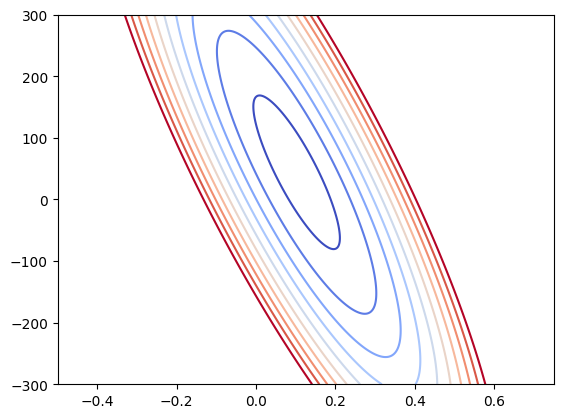

In [58]:
w_contour = np.linspace(-0.5, 0.75, 400)
b_contour = np.linspace(-300, 300, 400)
lvls[2] = np.arange(5000, 100000, 10000)
plotContour(w_contour, b_contour, X, y, LinearRegression.l2_loss, levels=lvls[2])

# Goal 3: Implement simplest optimization scheme: random local search
Hyperparameter: step size  
Algorithm: Each step, try random perturbation of parameters (of step size). If loss decreases, change, otherwise don't

### Random Local Search

In [59]:
class RandomLocalSearch(Optimizer):
    def __init__(self, loss) -> None:
        self.loss = loss
        super().__init__()
    
    def __call__(self, w, b, X, y, lr):
        w2 = w + np.random.normal(0, 1)*lr
        b2 = b + np.random.normal(0, 1)*lr
        if self.loss(FF(w2), FF(b2), X, y) < self.loss(FF(w), FF(b), X, y):
            return w2, b2
        return w, b

#### Functions

In [60]:
def do_rls_plot(w, b, w_step, b_step, contourw, contourb, X, y, loss, lvl):
    '''
    function only to be clean. not to be widely used
    '''
    model = LinearRegression(w, b, loss, optimizer=RandomLocalSearch(loss))
    pts = model.random_local_search(X, y, w_step, b_step, 400, ret_pts=1)
    print("approximate center: ", pts[-1])
    plotContour(contourw, contourb, X, y, loss, levels=lvl)
    plt.scatter(*zip(*pts))

#### Test Data

L1

In [61]:
do_rls_plot(0, 0, 0.2, 0.2, w_contour_toy_l1, b_contour_toy_l1, toy_X, toy_y, LinearRegression.l1_loss, lvl=toy_lvls[1])

AttributeError: 'LinearRegression' object has no attribute 'random_local_search'

L2

approximate center:  (-3.491363174896298, 12.985677240786998)


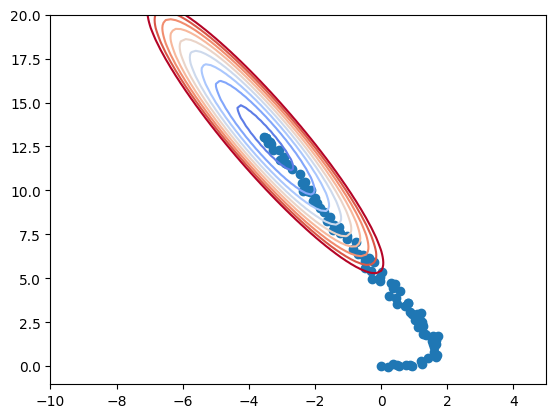

In [ ]:
do_rls_plot(0, 0, 0.2, 0.2, w_contour_toy_l2, b_contour_toy_l2, toy_X, toy_y, LinearRegression.l2_loss, lvl=toy_lvls[2])

#### My Data

L1

approximate center:  (0.09104363722415282, 47.94020853206229)


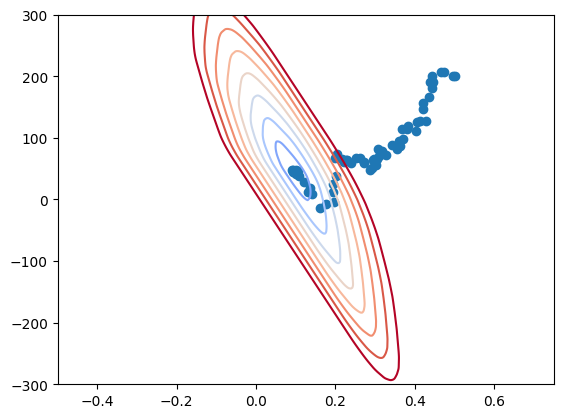

In [ ]:
do_rls_plot(0.5, 200, 0.01, 10, w_contour, b_contour, X, y, LinearRegression.l1_loss, lvl=lvls[1])

L2

approximate center:  (0.10213957350451393, 44.21880184428177)


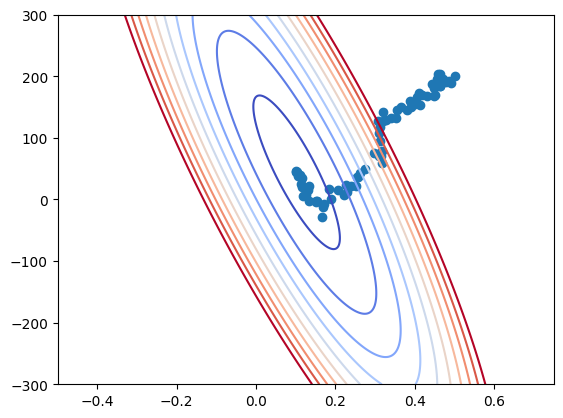

In [ ]:
do_rls_plot(0.5, 200, 0.01, 10, w_contour, b_contour, X, y, LinearRegression.l2_loss, lvl=lvls[2])

### Sortarandom Local Search


My approach to this is to have different (user-specified) changes for w and b at each step. This does not do exactly random local search, as the "randomness" is specified by the user. However, it is super clean and not noticably worse as with a little detail it works great. 

In [ ]:
class SortaRandomLocalSearch(Optimizer):
    def __init__(self, w_adds, b_adds, loss) -> None:
        super().__init__()
        self.w_adds = w_adds
        self.b_adds = b_adds
        self.loss = loss
    
    def __call__(self, w, b, X, y, lr) -> tuple[int, int]:
        w2 = w + self.w_adds
        b2 = b + self.b_adds
        ww, bb = np.meshgrid(w2, b2)
        temp = self.loss(ww, bb, X, y)
        pos = np.argmin(temp)
        return ww.flatten()[pos], bb.flatten()[pos]

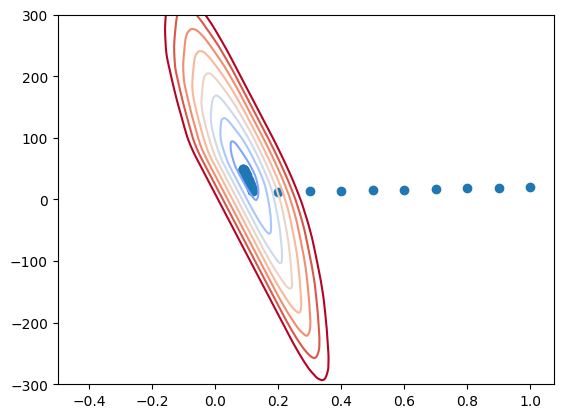

In [ ]:
w_space = np.linspace(-0.1, 0.1, 50)
b_space = np.linspace(-1, 1, 50)
w, b = 1, 20
model = LinearRegression(w, b, LinearRegression.l1_loss, optimizer=SortaRandomLocalSearch(w_space, b_space, LinearRegression.l1_loss))
ww, bb = model.train(X, y, 1, steps=50, ret_pts=1)
plotContour(w_contour, b_contour, X, y, LinearRegression.l1_loss, levels=np.arange(0, 150, 15))
plt.scatter(ww, bb)

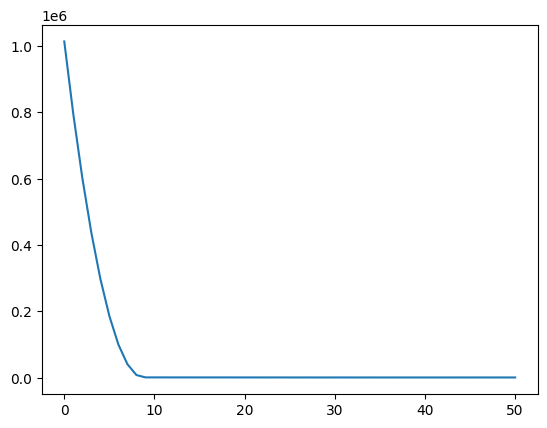

In [ ]:
x2 = np.arange(len(ww))
y2 = LinearRegression.l2_loss(ww, bb, X, y)
plt.plot(x2, y2)

# Goal 4: Explore Gradient Descent on Toy Example

## Non-Stochastic Without Momentum


### Functions

In [78]:
def do_grad_decent_1(w, b, X, y, contour_w, contour_b, levls, grad, loss, lr = 0.01, steps=300):
    model = LinearRegression(w, b, loss, grad)
    ws, bs = model.train(X, y, lr, steps, 1)

    plotContour(contour_w, contour_b, X, y, levels=levls, loss=loss)
    plt.scatter(ws, bs)
    plt.plot(ws, bs)

### Toy Example

#### only showing toy loss

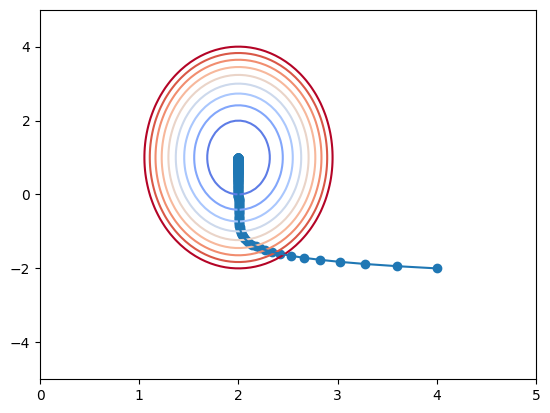

In [ ]:
do_grad_decent_1(4, -2, toy_X, toy_y, w_contour_toy, b_contour_toy, toy_lvls[2], LinearRegression.toy_grad, LinearRegression.toy_loss, 0.01)

#### Why the learning rate hyperparameter sucks

##### Exhibit A: Too small a learning rate (0.0001)

/var/folders/d0/dk6cszhs0x5d2_p1gnjcc9r40000gn/T/ipykernel_53698/3269788583.py:17: UserWarning: No contour levels were found within the data range.
  plt.contour(ww, bb, res, levels, cmap=cm.coolwarm)


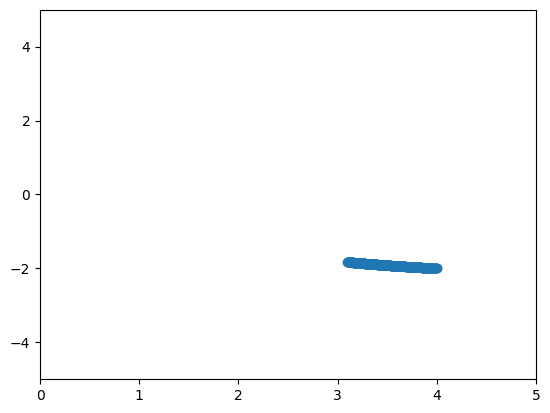

In [ ]:
do_grad_decent_1(4, -2, toy_X, toy_y, w_contour_toy, b_contour_toy, toy_lvls[2], LinearRegression.toy_grad, LinearRegression.l2_loss, 0.0001)

##### Exhibit B: A good learning rate (0.01)

on your colab notebook, this doesn't converge fully, but I am running it for 300 steps in this case instead of 10 so it does (figure 1 has an example of a too-slow rate for me)

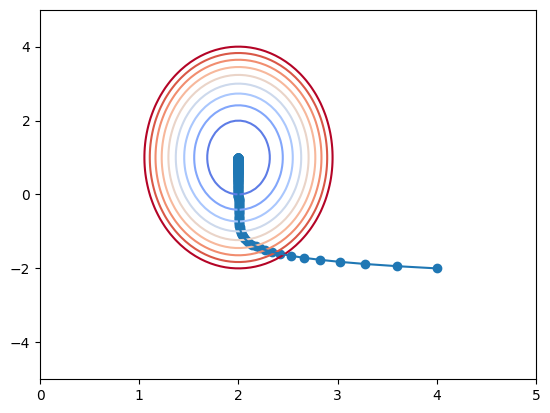

In [ ]:
do_grad_decent_1(4, -2, toy_X, toy_y, w_contour_toy, b_contour_toy, toy_lvls[2], LinearRegression.toy_grad, LinearRegression.toy_loss, 0.01)

##### Exhibit C: A chaotic learning rate (0.9)

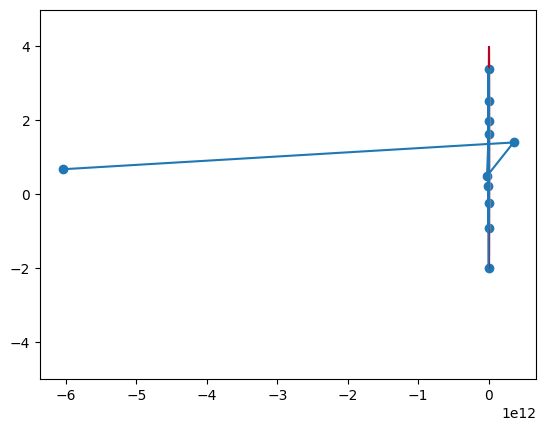

In [ ]:
do_grad_decent_1(-1, -2, toy_X, toy_y, w_contour_toy, b_contour_toy, toy_lvls[2], LinearRegression.toy_grad, LinearRegression.toy_loss, 0.9, 10)

##### Exhibit D: A cyclic learning rate (1)

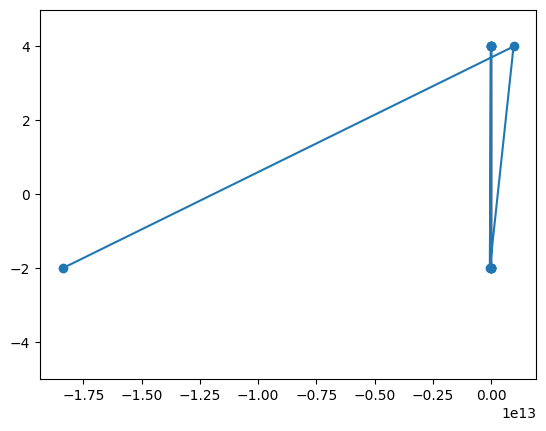

In [ ]:
do_grad_decent_1(-1, -2, toy_X, toy_y, w_contour_toy, b_contour_toy, toy_lvls[2], LinearRegression.toy_grad, LinearRegression.toy_loss, 1, 10)

##### Exhibit E: A divergent learning rate (1.1)

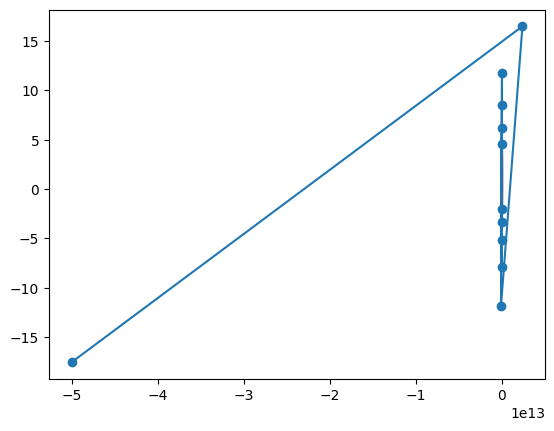

In [ ]:
do_grad_decent_1(-1, -2, toy_X, toy_y, w_contour_toy, b_contour_toy, toy_lvls[2], LinearRegression.toy_grad, LinearRegression.toy_loss, 1.1, 10)

### My Data

For these guys, I currently have to use 2 different learning rates as otherwise it would never reach given how far I'm keeping the start point from the center. I could make that a smaller distance but that would only shrink the problem and not solve it, this highlights the problem better.

#### L1

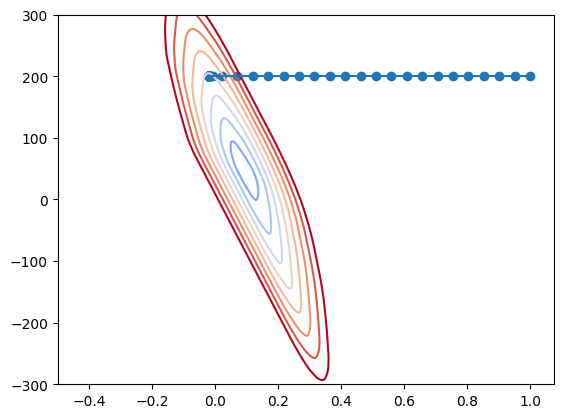

In [ ]:
do_grad_decent_1(1, 200, X, y, w_contour, b_contour, lvls[1], LinearRegression.l1_grad, LinearRegression.l1_loss, 0.00005)

#### L2 

/var/folders/d0/dk6cszhs0x5d2_p1gnjcc9r40000gn/T/ipykernel_53698/3269788583.py:17: UserWarning: No contour levels were found within the data range.
  plt.contour(ww, bb, res, levels, cmap=cm.coolwarm)


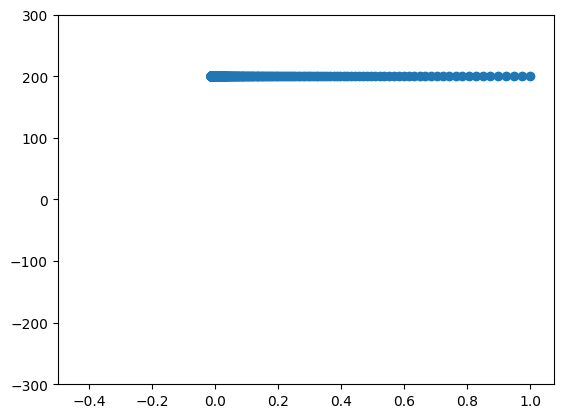

In [ ]:
do_grad_decent_1(1, 200, X, y, w_contour, b_contour, lvls[2], LinearRegression.l2_grad, LinearRegression.quickloss, 0.00000001)

## Non-Stochastic Using Momentum

In [75]:
def gradDecentWithMomentum(w, b, X, y, grad, n=300, mul=1, lr_w = 0.01, lr_b=0.01):
    """
    Using momentum to improve results for gradient decent. 
    My notion of momentum takes the previous momentum, multiplies it by some constant on [0, 1] and adds the current velocity to that momentum.  

    ---  
    w: the initial w for the algorithm  
    b: the iniital b for the algorithm  
    X: the list of input values to use for calculating the loss  
    y: the list of output values to use for calculating the loss  
    grad: the gradient function that returns dw and db
    n: the number of iterations of the algorithm 
    mul: the multiplier for previous velocities
    lr_w: the step size (learning rate) for w
    lr_b: the step size (learning rate) for b
    ret_pts: boolean for whether to return all points of the algorithm (`True`) or the final point found by the algorithm (`False`).
    """
    res_w, res_b = [], []
    momentum_w = 0
    momentum_b = 0
    for _ in range(n):
        dw, db = grad(w, b, X, y)
        momentum_w *= mul
        momentum_b *= mul
        momentum_w += dw
        momentum_b += db
        w -= lr_w * momentum_w
        b -= lr_b * momentum_b
        res_w.append(w)
        res_b.append(b)
    return np.array(res_w), np.array(res_b)

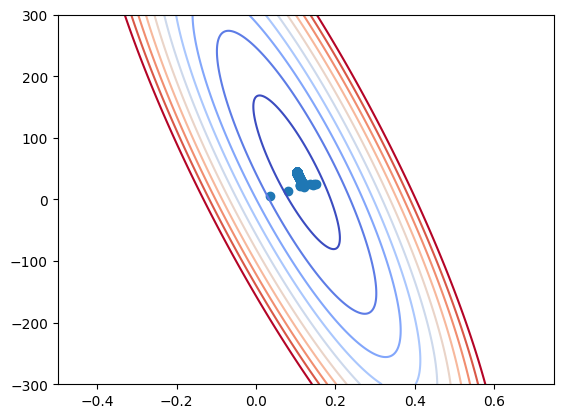

In [ ]:
ws_momentum, bs_momentum = gradDecentWithMomentum(0, 0, X, y, LinearRegression.l2_grad, 300, 0.6, 0.0000001, 0.02)
plotContour(w_contour, b_contour, X, y, levels=lvls[2], loss=LinearRegression.l2_loss)
plt.scatter(ws_momentum, bs_momentum, )

## Stochastic Using Momentum

In [70]:
def SGDWithMomentum(w, b, X, y, grad, n=300, mul=1, lr_w = 0.01, lr_b=0.01):
    """
    Using momentum to improve results for gradient decent. 
    My notion of momentum takes the previous momentum, multiplies it by some constant on [0, 1] and adds the current velocity to that momentum.  

    ---  
    w: the initial w for the algorithm  
    b: the iniital b for the algorithm  
    X: the list of input values to use for calculating the loss  
    y: the list of output values to use for calculating the loss  
    grad: the gradient function that returns dw and db
    n: the number of iterations of the algorithm 
    mul: the multiplier for previous velocities
    lr_w: the step size (learning rate) for w
    lr_b: the step size (learning rate) for b
    ret_pts: boolean for whether to return all points of the algorithm (`True`) or the final point found by the algorithm (`False`).
    """
    res_w, res_b = [], []
    momentum_w = 0
    momentum_b = 0
    nums = np.arange(len(X))
    for _ in range(n):
        sampl = np.random.choice(nums, (100,))
        X_2, y_2 = X[sampl], y[sampl]
        dw, db = grad(w, b, X_2, y_2)
        momentum_w *= mul
        momentum_b *= mul
        momentum_w += dw
        momentum_b += db
        w -= lr_w * momentum_w
        b -= lr_b * momentum_b
        res_w.append(w)
        res_b.append(b)
    return np.array(res_w), np.array(res_b)

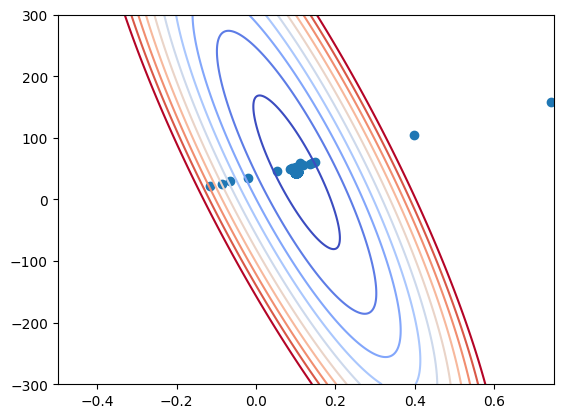

In [ ]:
ws_sgd, bs_sgd = SGDWithMomentum(1, 200, X, y, l2_grad, 300, 0.6, 0.0000001, 0.02)
plotContour(w_contour, b_contour, X, y, pw = 2, levels=lvls[2])
plt.scatter(ws_sgd, bs_sgd)

# Issue: Ellipsoids are long and skinny

## Solution idea #1: rescale data

### Helper Fns

In [67]:
def apply_subtract_and_div(data, minus, div):
    return (data-minus)/div

def undo_b(w, b, minus, div, mul, add):
    return (b-minus*w/div)*mul + add

def undo_w(w, mul, div):
    return w*mul/div

### Normalization

In [ ]:
def normalize(X, y):
    X_normed = apply_subtract_and_div(X, np.min(X), np.max(X)-np.min(X))
    y_normed = apply_subtract_and_div(y, np.min(y), np.max(y)-np.min(y))
    return X_normed, y_normed

def denormalize_wb(X, y, w, b):
    orig_w = undo_w(w, np.max(y)-np.min(y), np.max(X)-np.min(X))
    orig_b = undo_b(w, b, np.min(X), np.max(X)-np.min(X), np.max(y)-np.min(y), np.min(y))
    return orig_w, orig_b


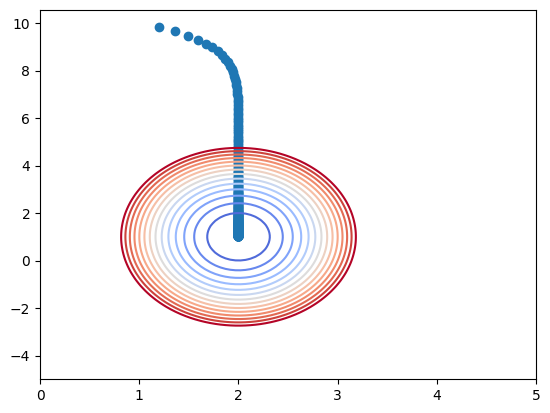

In [ ]:
X_normed_toy, y_normed_toy = normalize(toy_X, toy_y)
ws_normed_sgd_toy, bs_normed_sgd_toy = gradDecentWithMomentum(1, 10, X_normed_toy, y_normed_toy, toy_grad, 300, 0, 0.01, 0.01)
plotContour(w_contour_toy, b_contour_toy, toy_X, toy_y, pw = 1, levels=toy_lvls[1], loss=toy_loss)
# this is sorcery, the below line should not work, rather the commented out one, but for whatever reason it aint the case
plt.scatter(ws_normed_sgd_toy, bs_normed_sgd_toy)
# plt.scatter(*denormalize_wb(toy_X, toy_y, ws_normed_sgd_toy, bs_normed_sgd_toy))

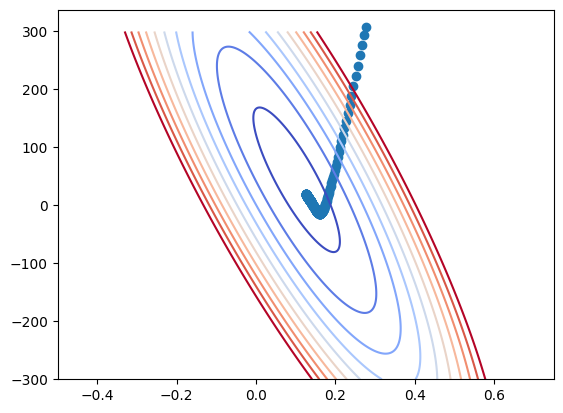

In [ ]:
X_normed, y_normed = normalize(X, y)
ws_normed_sgd, bs_normed_sgd = SGDWithMomentum(2, 1, X_normed, y_normed, LinearRegression.l2_grad, 300, 0.6, 0.01, 0.01)
plotContour(w_contour, b_contour, X, y, pw = 2, levels=lvls[2])
plt.scatter(*denormalize_wb(X, y, ws_normed_sgd, bs_normed_sgd))

### Standardization

In [68]:
def standardize(X, y):
    X_std = apply_subtract_and_div(X, np.mean(X), np.std(X))
    y_std = apply_subtract_and_div(y, np.mean(y), np.std(y))
    return X_std, y_std

def destandardize_wb(X, y, w, b):
    w_orig = undo_w(w, np.std(y), np.std(X))
    b_orig = undo_b(w, b, np.mean(X), np.std(X), np.std(y), np.mean(y))
    return w_orig, b_orig

In [71]:
X_std, y_std = standardize(toy_X, toy_y)
ws_normed_sgd, bs_normed_sgd = SGDWithMomentum(1, 10, X_normed, y_normed, LinearRegression.toy_grad, 300, 0, 0.01, 0.01)
plotContour(w_contour_toy, b_contour_toy, X_normed, y_normed, pw = 1, levels=toy_lvls[1], loss=LinearRegression.toy_loss)
print(ws_normed_sgd[-1], bs_normed_sgd[-1])
plt.scatter(ws_normed_sgd, bs_normed_sgd)

NameError: name 'X_normed' is not defined

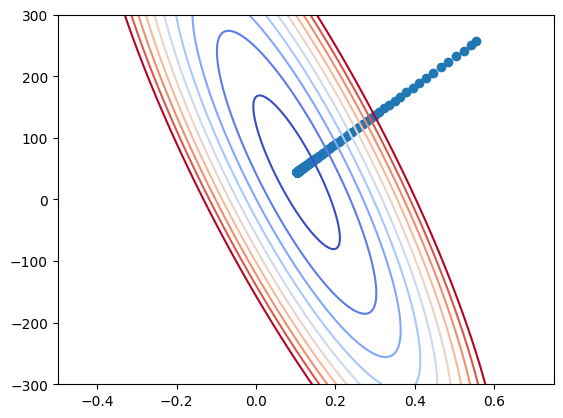

In [80]:
X_std, y_std = standardize(X, y)
ws_std_sgd, bs_std_sgd = gradDecentWithMomentum(5, 10, X_std, y_std, LinearRegression.l2_grad, 300, 0.6, 0.01, 0.01)
plotContour(w_contour, b_contour, X, y, levels=lvls[2], loss=LinearRegression.l2_loss)
plt.scatter(*destandardize_wb(X, y, ws_std_sgd, bs_std_sgd))

## Solution idea #2: try better optimization schemes

# Credits

Jasper ofc

Thomas for giving me a hint to how to compute the derivatives for L1 loss, which I just took and extended to L2

https://stackoverflow.com/questions/5086789/python-is-there-an-inverse-for-ndarray-flattenf